In [29]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import requests
import json
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import hvplot.pandas

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import alpaca_trade_api as tradeapi
import datetime
from dateutil.relativedelta import relativedelta

import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import p2_FMP_Requests as fmp

# Load the environment variables from the .env file
load_dotenv()

fmp_apikey = os.getenv("FMP_API_KEY")
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

## Initializations

In [30]:
filepath = './Resources/NVDA_data.csv'
ticker = 'NVDA'
num_days = "1000"
short_window = 4
long_window = 20

___
## Get Data

In [31]:
## Get data from file
data = pd.read_csv(filepath, index_col='date', parse_dates=True, infer_datetime_format=True)
data

In [32]:
# ## Get live data from FinancialModellingPrep.com
# data_hist_price_response = fmp.get_historial_daily_stock_price_last_x_days(ticker, num_days, fmp_apikey)
# data_hist_price_df = pd.DataFrame(data_hist_price_response['historical']).drop('label', axis=1).set_index('date')

# data = data_hist_price_df.sort_index(ascending=True)
# data = data.drop(['unadjustedVolume', 'adjClose', 'change', 'changePercent', 'changeOverTime'], axis=1)

# data.to_csv(filepath)
# data

,open,high,low,close,volume,vwap
date,,,,,,
2018-10-11,60.542499,61.889999,58.564999,58.782501,72543600.0,59.58779
2018-10-12,61.377499,62.384998,59.912498,61.634998,60823600.0,61.14512
2018-10-15,61.500000,61.500000,58.834999,58.845001,44976000.0,59.56845
2018-10-16,59.982498,61.570000,59.485001,61.457501,40871200.0,60.67227
2018-10-17,62.084999,62.470001,60.270001,60.764999,32966800.0,61.00496
...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000


In [33]:
## Get live data from Alpaca Markets

# # Create the Alpaca tradeapi.REST object
# alpaca = tradeapi.REST(
#     alpaca_api_key,
#     alpaca_secret_key,
#     api_version = "v2"
# )

# # Set start and end dates
# today = datetime.datetime.today().date()
# back = today - relativedelta(years=10)
# print(today,back)

# start_date = pd.Timestamp(back, tz="America/New_York").isoformat()
# end_date = pd.Timestamp(today, tz="America/New_York").isoformat()
# print(start_date, end_date)

# closing_prices_df = alpaca.get_bars("NVDA", TimeFrame.Day, start_date, end_date, adjustment='raw').df

# data.to_csv(filepath)


___
## Use Technical Indicators to generate features

#### Feature - CCI (Commodity Channel Index)

In [34]:
days = 20
TP = (data['high'] + data['low'] + data['close']) / 3
CCI = pd.Series((TP - TP.rolling(window=days).mean()) / (0.015 * TP.rolling(window=days).std()), name = 'CCI')
data = pd.concat([data, CCI], axis=1)

#### Feature - EVM (Ease of Movement)

In [35]:
days = 14
dm = ((data['high'] + data['low'])/2) - ((data['high'].shift(1) + data['low'].shift(1))/2)
br = (data['volume'] / 100000000) / ((data['high'] - data['low']))
EVM = dm / br 
EVM_MA = pd.Series(EVM.rolling(window=days).mean(), name = 'EVM')
data = pd.concat([data, EVM_MA], axis=1)


#### Features - SMA (Simple Moving Average) & EWMA (Exponentially Weighted Moving Average)

In [36]:
def SMA(data, days): 
    close = data['close']
    sma = pd.Series(close.rolling(window=days).mean(), name = ('SMA_' + str(days)))
    data = pd.concat([data, sma], axis=1)
    return data

In [37]:
def EWMA(data, days):
    close = data['close']
    ema = pd.Series(close.ewm(span = days, min_periods = (days - 1)).mean(), name = 'EWMA_' + str(days))
    data = pd.concat([data, ema], axis=1)
    return data

In [38]:
# Calculate SMAs

days_list = [short_window,long_window,100,200]
for days in days_list:
    data = SMA(data, days)
    data = EWMA(data, days)


#### Feature - ROC (price Rate Of Change)

In [39]:
N = data['close'].diff(days)
D = data['close'].shift(days)
roc = pd.Series(N/D,name='ROC')
data = pd.concat([data, roc], axis=1)


#### Feature - Bolinger Bands

In [40]:
MA = data.close.rolling(window=days).mean()
SD = data.close.rolling(window=days).std()
data['UpperBB'] = MA + (2 * SD) 
data['LowerBB'] = MA - (2 * SD)


#### Feature - Force Index

In [41]:
FI = pd.Series(data['close'].diff(days) * data['volume'], name = 'ForceIndex') 
data = data = pd.concat([data, FI], axis=1)


In [42]:
data = data.dropna().astype('float')
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-07-31,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,42.090125,42.215500,41.825275,40.889356,41.548412,41.031155,-0.282440,53.797139,29.299686,-5.967204e+08
2019-08-01,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,42.117250,42.121642,41.834725,40.896223,41.446387,41.033436,-0.331062,53.357791,29.534984,-8.594830e+08
2019-08-02,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,42.129251,41.947915,41.831400,40.884159,41.353650,41.025007,-0.315192,53.006496,29.700804,-7.944785e+08
2019-08-05,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,42.049000,41.543113,41.786825,40.819971,41.234850,40.986948,-0.386609,52.543115,29.926584,-1.399835e+09
2019-08-06,38.450001,38.907501,37.607498,38.087502,36127200.0,38.13843,-143.158133,-0.981383,39.328125,39.235496,41.987000,41.214007,41.753800,40.764951,41.121462,40.953836,-0.373200,52.092215,30.150709,-8.192745e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,136.758998,138.546698,165.409600,169.916485,207.866000,188.070712,-0.615786,307.571537,108.160462,-1.072683e+10
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,135.064998,137.173679,164.617500,169.009822,206.962150,187.434456,-0.592883,306.408572,107.515728,-1.001275e+10
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,133.698999,136.239043,164.006700,168.185073,206.089050,186.836672,-0.578250,305.247599,106.930500,-9.452187e+09


___
## Generate Trading Signals using short and long SMA. Calculate P&L and ROI.

In [43]:
# Create a column to hold the trading signal
data['Signal'] = 0.0

In [44]:
# Generate the trading signal 0 or 1,
# where 1 is the short-window greater than the long-window
# and 0 is when the condition is not met

SMA_short = ('SMA_' + str(short_window))
SMA_long = ('SMA_' + str(long_window))

data['Signal'][short_window:] = np.where(
    data[SMA_short][short_window:] > data[SMA_long][short_window:], 1.0, 0.0
)

data.tail(10)

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal
date,,,,,,,,,,,,,,,,,,,,,
2022-09-19,130.119995,134.630005,130.100006,133.820007,56968500.0,132.85001,-61.375181,-22.688435,131.592499,133.072309,...,146.073194,168.6233,174.390417,212.53435,191.179948,-0.574296,314.257634,110.811065,-1.028452e+10,0.0
2022-09-20,132.149994,134.830002,130.570007,131.759995,52481800.0,132.38667,-57.597550,-17.390914,131.712498,132.547383,...,144.710032,168.0994,173.546250,211.58685,190.588676,-0.589865,312.767627,110.406072,-9.945302e+09,0.0
2022-09-21,132.130005,140.309998,131.100006,132.610001,80767900.0,134.67333,-42.900563,-12.331995,132.542500,132.572430,...,143.557648,167.4473,172.735632,210.71525,190.011746,-0.567947,311.597109,109.833390,-1.407946e+10,0.0
2022-09-22,130.699997,131.490005,124.279999,125.610001,75916200.0,127.12667,-72.602895,-8.056312,130.950001,129.787458,...,141.848348,166.8487,171.802451,209.84145,189.370901,-0.581816,310.628844,109.054056,-1.326711e+10,0.0
2022-09-23,124.199997,126.110001,122.570000,125.160004,66184000.0,124.61333,-85.476138,-9.723110,128.785000,127.936476,...,140.258982,166.1470,170.878838,208.84590,188.731956,-0.614025,309.021048,108.670752,-1.317790e+10,0.0
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,...,138.546698,165.4096,169.916485,207.86600,188.070712,-0.615786,307.571537,108.160462,-1.072683e+10,0.0
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,...,137.173679,164.6175,169.009822,206.96215,187.434456,-0.592883,306.408572,107.515728,-1.001275e+10,0.0
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,...,136.239043,164.0067,168.185073,206.08905,186.836672,-0.578250,305.247599,106.930500,-9.452187e+09,0.0
2022-09-29,124.480000,125.000000,119.460100,122.200000,53128856.0,122.22003,-106.393001,-13.703908,123.992500,124.466679,...,134.901991,163.3612,167.274477,205.29200,186.193492,-0.566067,304.572800,106.011199,-8.469270e+09,0.0


In [45]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
data['Entry/Exit'] = data['Signal'].diff()
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit
date,,,,,,,,,,,,,,,,,,,,,
2019-07-31,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,...,41.825275,40.889356,41.548412,41.031155,-0.282440,53.797139,29.299686,-5.967204e+08,0.0,NaN
2019-08-01,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,...,41.834725,40.896223,41.446387,41.033436,-0.331062,53.357791,29.534984,-8.594830e+08,0.0,0.0
2019-08-02,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,...,41.831400,40.884159,41.353650,41.025007,-0.315192,53.006496,29.700804,-7.944785e+08,0.0,0.0
2019-08-05,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,...,41.786825,40.819971,41.234850,40.986948,-0.386609,52.543115,29.926584,-1.399835e+09,0.0,0.0
2019-08-06,38.450001,38.907501,37.607498,38.087502,36127200.0,38.13843,-143.158133,-0.981383,39.328125,39.235496,...,41.753800,40.764951,41.121462,40.953836,-0.373200,52.092215,30.150709,-8.192745e+08,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,...,165.409600,169.916485,207.866000,188.070712,-0.615786,307.571537,108.160462,-1.072683e+10,0.0,0.0
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,...,164.617500,169.009822,206.962150,187.434456,-0.592883,306.408572,107.515728,-1.001275e+10,0.0,0.0
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,...,164.006700,168.185073,206.089050,186.836672,-0.578250,305.247599,106.930500,-9.452187e+09,0.0,0.0


In [46]:
data['Entry/Exit'].value_counts()

 0.0    747
 1.0     26
-1.0     26
Name: Entry/Exit, dtype: int64

In [47]:
# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


In [48]:
# Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)


In [49]:
# Visualize close price for the investment
security_close = data[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)


In [50]:
# Visualize moving averages
moving_avgs = data[[SMA_short, SMA_long]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)


In [51]:
# Create the overlay plot
entry_exit_plot = moving_avgs * security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': SMA_short, SMA_long, Entry and Exit Points')
)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I          :Curve   [date]   (close)
   .Scatter.Close.I  :Scatter   [date]   (close)
   .Scatter.Close.II :Scatter   [date]   (close)

#### Execute trades based on the entry/exit signals and calculate P&L

In [52]:
# Add the trade_type column to track buys and sells
data['trade_type'] = np.nan

In [53]:
# Initialize a cost/proceeds column for recording trade metrics
data["cost/proceeds"] = np.nan

In [54]:
# Initialize share size and accumulated shares
share_size = 100
accumulated_shares = 0
bought = False
initial_investment = 0

In [55]:
# Loop through the Pandas DataFrame and initiate a trade at each iteration
for index, row in data.iterrows():

    # buy if the previous_price is 0, in other words, buy on the first day
    if row["Entry/Exit"] == 1:
        data.loc[index, "trade_type"] = "buy"

        bought = True  # indicate stock has been bought

        if initial_investment == 0:
            initial_investment = row["close"] * share_size

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size

    # buy if the current day's price is less than the previous day's price
    elif row["Entry/Exit"] == -1 and bought: #able to sell only when stock has first been bought
        data.loc[index, "trade_type"] = "sell"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        data.loc[index, "cost/proceeds"] = (row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares -= share_size

    # hold if the current day's price is equal to the previous day's price
    else:
        data.loc[index, "trade_type"] = "hold"

    # if the index is the last index of the DataFrame and there is still accumulated stock, sell the remaining holding
    if index == data.index[-1] and accumulated_shares !=0:
        data.loc[index, "trade_type"] = "sell"

        # calculate the proceeds by multiplying the last day's price by the accumulated shares
        data.loc[index, "cost/proceeds"] = row["close"] * accumulated_shares

        accumulated_shares = 0

In [56]:
data

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,...,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex,Signal,Entry/Exit,trade_type,cost/proceeds
date,,,,,,,,,,,,,,,,,,,,,
2019-07-31,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,...,41.548412,41.031155,-0.282440,53.797139,29.299686,-5.967204e+08,0.0,NaN,hold,NaN
2019-08-01,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,...,41.446387,41.033436,-0.331062,53.357791,29.534984,-8.594830e+08,0.0,0.0,hold,NaN
2019-08-02,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,...,41.353650,41.025007,-0.315192,53.006496,29.700804,-7.944785e+08,0.0,0.0,hold,NaN
2019-08-05,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,...,41.234850,40.986948,-0.386609,52.543115,29.926584,-1.399835e+09,0.0,0.0,hold,NaN
2019-08-06,38.450001,38.907501,37.607498,38.087502,36127200.0,38.13843,-143.158133,-0.981383,39.328125,39.235496,...,41.121462,40.953836,-0.373200,52.092215,30.150709,-8.192745e+08,0.0,0.0,hold,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,...,207.866000,188.070712,-0.615786,307.571537,108.160462,-1.072683e+10,0.0,0.0,hold,NaN
2022-09-27,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,...,206.962150,187.434456,-0.592883,306.408572,107.515728,-1.001275e+10,0.0,0.0,hold,NaN
2022-09-28,124.100000,128.230000,123.550000,127.360000,54130032.0,126.38000,-68.439686,-7.854277,124.732501,125.977799,...,206.089050,186.836672,-0.578250,305.247599,106.930500,-9.452187e+09,0.0,0.0,hold,NaN


In [57]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("accumulated_shares =", accumulated_shares)

accumulated_shares = 0


In [58]:
print (f"The investment made is ${initial_investment:,.2f}" )

The investment made is $4,280.75


In [59]:
# Calculate the total profit/loss for 100 share size orders
total_profit_loss = data["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

The total profit/loss of the trading strategy is $6,271.00


In [60]:
# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_investment) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

The trading algorithm resulted in a return on investment of 146.49%


In [61]:
# # store file for checking trades using Excel
# filepath = Path(./Resources/'data.csv')   
# data.to_csv(filepath)

---
## Machine Learning

In [62]:
data_ml = data.shift().drop(columns=['Entry/Exit', 'trade_type', 'cost/proceeds']).dropna()
X = data_ml.drop(columns=['Signal'])
X

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-08-01,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,42.090125,42.215500,41.825275,40.889356,41.548412,41.031155,-0.282440,53.797139,29.299686,-5.967204e+08
2019-08-02,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,42.117250,42.121642,41.834725,40.896223,41.446387,41.033436,-0.331062,53.357791,29.534984,-8.594830e+08
2019-08-05,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,42.129251,41.947915,41.831400,40.884159,41.353650,41.025007,-0.315192,53.006496,29.700804,-7.944785e+08
2019-08-06,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,42.049000,41.543113,41.786825,40.819971,41.234850,40.986948,-0.386609,52.543115,29.926584,-1.399835e+09
2019-08-07,38.450001,38.907501,37.607498,38.087502,36127200.0,38.13843,-143.158133,-0.981383,39.328125,39.235496,41.987000,41.214007,41.753800,40.764951,41.121462,40.953836,-0.373200,52.092215,30.150709,-8.192745e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.199997,126.110001,122.570000,125.160004,66184000.0,124.61333,-85.476138,-9.723110,128.785000,127.936476,138.774998,140.258982,166.147000,170.878838,208.845900,188.731956,-0.614025,309.021048,108.670752,-1.317790e+10
2022-09-27,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,136.758998,138.546698,165.409600,169.916485,207.866000,188.070712,-0.615786,307.571537,108.160462,-1.072683e+10
2022-09-28,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,135.064998,137.173679,164.617500,169.009822,206.962150,187.434456,-0.592883,306.408572,107.515728,-1.001275e+10


In [63]:
# Review the value counts
y = data_ml['Signal']
y.value_counts()

1.0    476
0.0    323
Name: Signal, dtype: int64

In [64]:
y

date
2019-08-01    0.0
2019-08-02    0.0
2019-08-05    0.0
2019-08-06    0.0
2019-08-07    0.0
             ... 
2022-09-26    0.0
2022-09-27    0.0
2022-09-28    0.0
2022-09-29    0.0
2022-09-30    0.0
Name: Signal, Length: 799, dtype: float64

In [65]:
# Split train - test data
split_ratio=0.8
train_size = int(round(split_ratio * X.shape[0]))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(639, 20) (639,)
(160, 20) (160,)


In [66]:
# Review the X_train DataFrame
X_train

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2019-08-01,43.544998,43.555000,41.755001,42.180000,35941600.0,42.42756,19.471978,-0.021696,43.378751,43.117155,42.090125,42.215500,41.825275,40.889356,41.548412,41.031155,-0.282440,53.797139,29.299686,-5.967204e+08
2019-08-02,42.285000,43.195000,40.705002,41.229999,42121200.0,41.64245,-17.138823,-0.433732,42.744375,42.362293,42.117250,42.121642,41.834725,40.896223,41.446387,41.033436,-0.331062,53.357791,29.534984,-8.594830e+08
2019-08-05,40.297501,40.994999,39.820000,40.297501,42834800.0,40.30481,-78.808481,-0.675604,41.892500,41.536376,42.129251,41.947915,41.831400,40.884159,41.353650,41.025007,-0.315192,53.006496,29.700804,-7.944785e+08
2019-08-06,38.450001,38.462502,37.224998,37.697498,58915600.0,37.73323,-170.457578,-1.011706,40.351250,40.000825,42.049000,41.543113,41.786825,40.819971,41.234850,40.986948,-0.386609,52.543115,29.926584,-1.399835e+09
2019-08-07,38.450001,38.907501,37.607498,38.087502,36127200.0,38.13843,-143.158133,-0.981383,39.328125,39.235496,41.987000,41.214007,41.753800,40.764951,41.121462,40.953836,-0.373200,52.092215,30.150709,-8.192745e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,244.580002,250.770004,237.800003,239.479996,41017800.0,242.62917,-29.176123,-75.572482,245.785000,242.463663,251.109001,251.051193,263.136700,258.061756,224.012862,230.495622,0.559064,327.907765,120.117960,3.522404e+09
2022-02-07,239.720001,246.350006,236.320007,243.190002,35482900.0,241.89832,-26.772034,-67.538563,245.367500,242.754199,249.179501,250.302508,263.344400,257.767266,224.486300,230.621964,0.637616,327.859568,121.113032,3.359787e+09
2022-02-08,243.720001,251.820007,242.020004,247.279999,37686800.0,246.98407,-4.195670,-49.865555,245.592499,244.564519,247.920001,250.014650,263.583100,257.559597,224.959437,230.787754,0.619888,327.876178,122.042697,3.566208e+09


In [67]:
# Review the X_test DataFrame
X_test

,open,high,low,close,volume,vwap,CCI,EVM,SMA_4,EWMA_4,SMA_20,EWMA_20,SMA_100,EWMA_100,SMA_200,EWMA_200,ROC,UpperBB,LowerBB,ForceIndex
date,,,,,,,,,,,,,,,,,,,,
2022-02-11,259.950012,269.250000,256.000000,258.239990,51320000.0,261.10491,70.148718,24.080652,255.912495,256.369449,245.130500,252.348970,264.8213,257.634000,226.534462,231.616239,0.690412,328.259499,124.809426,5.412848e+09
2022-02-14,259.160004,261.519989,237.729996,239.490005,60547200.0,246.19249,9.926765,24.773712,253.964996,249.617672,243.817500,251.124307,265.0916,257.274713,226.965675,231.694603,0.562766,328.171653,125.759697,5.221742e+09
2022-02-15,239.339996,248.750000,237.550003,242.669998,44042400.0,242.93511,-0.000001,9.591872,251.862495,246.838602,242.480000,250.319134,265.3242,256.985510,227.428550,231.803835,0.616776,328.066366,126.790734,4.077225e+09
2022-02-16,249.490005,265.450012,247.839996,264.950012,69986900.0,259.35340,90.060909,22.108899,251.337502,254.083166,242.776000,251.712551,265.7255,257.143223,228.011462,232.133719,0.785769,328.157663,127.865262,8.159249e+09
2022-02-17,262.589996,265.820007,255.520004,265.109985,73267600.0,262.09003,99.594700,36.078671,253.055000,258.493894,243.498000,252.988497,266.1685,257.300981,228.619450,232.461912,0.847295,328.178079,129.060820,8.909156e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,124.199997,126.110001,122.570000,125.160004,66184000.0,124.61333,-85.476138,-9.723110,128.785000,127.936476,138.774998,140.258982,166.1470,170.878838,208.845900,188.731956,-0.614025,309.021048,108.670752,-1.317790e+10
2022-09-27,124.910004,126.589996,122.139999,122.279999,54734300.0,123.67000,-91.663655,-7.905404,126.415001,125.673885,136.758998,138.546698,165.4096,169.916485,207.866000,188.070712,-0.615786,307.571537,108.160462,-1.072683e+10
2022-09-28,125.070000,127.360000,122.580000,124.130000,55389461.0,124.69000,-83.032228,-7.717566,124.295001,125.056331,135.064998,137.173679,164.6175,169.009822,206.962150,187.434456,-0.592883,306.408572,107.515728,-1.001275e+10


In [68]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Use the 'XGBoost' classifier model to fit the training data and make predictions based on the testing data.

In [69]:
# Instantiate XGB classifier model instance
model = xgb.XGBClassifier()
 
# Fit the model to the data using the training data
model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
pred = model.predict(X_test_scaled)

# Review the model's predicted values
pred[:10]

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [70]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Print the classification report
print(testing_report)

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       104
         1.0       0.98      0.86      0.91        56

    accuracy                           0.94       160
   macro avg       0.95      0.92      0.94       160
weighted avg       0.95      0.94      0.94       160



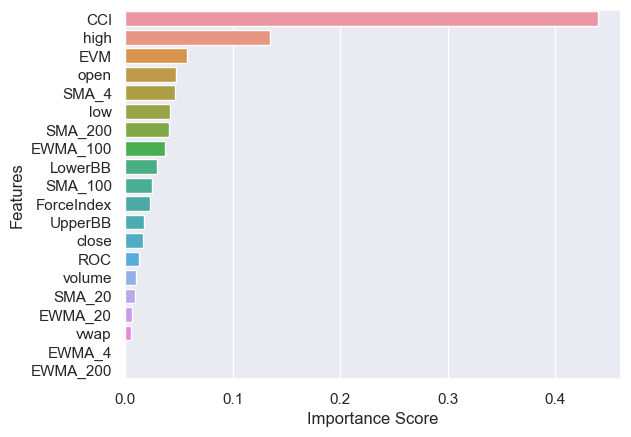

In [71]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()